In [ ]:
import os

import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [70]:
def find_feature_extraction_files(directory):
    """
    Searches for 'feature_extraction.csv' files within each subdirectory of a given directory.
    
    Args:
    directory (str): The path to the directory to search within.
    
    Returns:
    list: A list of full paths to each 'feature_extraction.csv' file found.
    """
    csv_files = []
    # Walk through each subdirectory in the provided directory
    for root, dirs, files in os.walk(directory):
        # Check if 'feature_extraction.csv' is in the files list
        if 'feature_extraction.csv' in files:
            # Construct full path and add to the list
            full_path = os.path.join(root, 'feature_extraction.csv')
            csv_files.append(full_path)
            
    return csv_files


In [71]:
def read_csv(data_file_path):
    
    df_read_file = pd.read_csv(data_file_path)
    df_Acc = df_read_file.loc[:, :"Label"]
    X_data = df_Acc.to_numpy()
    
    y_data = df_read_file.loc[:,"Label"]
    y_data = np.around(y_data, decimals=0)

    return X_data, y_data

def normalize_positions(data):
    posX_columns = [0] + list(range(4, 22))   # Adjusted for 0-based indexing: Columns 0 and 4 to 21 for PosX normalization
    posY_columns = [1] + list(range(22, 39))  # Adjusted for 0-based indexing: Columns 1 and 22 to 38 for PosY normalization
    
    # Normalize PosX columns
    data[:, posX_columns] = data[:, posX_columns] / 1920
    # Normalize PosY columns
    data[:, posY_columns] = data[:, posY_columns] / 1080
            
    return data

def handle_indices(data, indexes_of_labels, label_value=0, label_col=0):
    # Ensure data is a single column NumPy array
    data = data[:, label_col] if data.ndim > 1 else data
    

    found_indexes = set(indexes_of_labels)  # Using a set to avoid duplicates

    if indexes_of_labels:
        # Handling '0' label exactly 3 lines before the first label
        first_label_index = indexes_of_labels[0]
        target_index_before_first = first_label_index - 3
        if 0 <= target_index_before_first < len(data) and data[target_index_before_first] == label_value:
            found_indexes.add(target_index_before_first)

        # Handling '0' label exactly 3 lines after the last label
        last_label_index = indexes_of_labels[-1]
        target_index_after_last = last_label_index + 3
        if 0 <= target_index_after_last < len(data) and data[target_index_after_last] == label_value:
            found_indexes.add(target_index_after_last)

        # Handling the '0' label in the middle between given label indices
        for i in range(len(indexes_of_labels) - 1):
            start_index = indexes_of_labels[i]
            end_index = indexes_of_labels[i + 1]
            middle_index = (start_index + end_index) // 2
            if data[middle_index] == label_value:
                found_indexes.add(middle_index)

    # Convert set to a sorted list
    sorted_indexes = sorted(found_indexes)
    
    return sorted_indexes


def lstm_data_transform(x_data, y_data, keys, num_steps=6):
    X, y = list(), list()
    
    # Loop over the provided end indexes
    for end_ix in keys:
        # Calculate the start index for the current window
        start_ix = end_ix - num_steps + 1
        
        # Ensure the start index is not negative
        if start_ix < 0:
            continue
        
        # Get a sequence of data for x
        seq_X = x_data[start_ix:end_ix + 1, :-1]
        
        # Check if the sequence has the correct number of steps
        if seq_X.shape[0] == num_steps:

            # Append the sequence and target to the lists
            X.append(seq_X)
    
    # Convert the lists to numpy arrays
    x_array = np.array(X)
    y_array = np.array([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0])
    
    return x_array, y_array

In [72]:
def extract_relevant_rows(csv_path):
    x_array, y_array = read_csv(csv_path)
    
    # Normalize the position columns
    x_array = normalize_positions(x_array)

    # Define the values to check
    values_to_check = {1, 2, 3, 4, 5}

    # Find the indexes of values in y_array that are in values_to_check
    indexes_of_labels = [index for index, value in enumerate(y_array) if value in values_to_check]

    sorted_indices = handle_indices(y_array, indexes_of_labels)
    
    # print('Sorted indices: ', sorted_indices)
    
    if len(sorted_indices) <= 10:
        
        print(csv_path)

    x_data, y_data = lstm_data_transform(x_array, y_array, sorted_indices, num_steps=6)

    return x_data, y_data


In [90]:
# Example of how to call this function for one CSV file
file_paths = find_feature_extraction_files('Frames')

print(len(file_paths))


1735


In [91]:
num_of_steps = 6
num_of_input_signals = 55

X_data = np.empty([0, num_of_steps, num_of_input_signals], dtype="float32")
y_data = np.empty([0], dtype="float32")

for file_path in file_paths:
    
    data, labels = extract_relevant_rows(file_path)
    
    # print(labels.shape)
    
    X_data = np.append(X_data, data[:], axis=0)
    
    # print(labels.shape)
    y_data = np.append(y_data, labels, axis=0)
    
print(X_data.shape)   # This should show (x, 6, 55) if  everything is correctly configured
print(y_data.shape)  


(19085, 6, 55)
(19085,)


In [92]:
def one_hot_encode_labels(y_data):
    encoder = OneHotEncoder(sparse_output=False)
    y_data_encoded = encoder.fit_transform(y_data)

    return y_data_encoded

In [93]:
# # # One-hot encode the labels
# final_labels_encoded = one_hot_encode_labels(y_data.reshape(-1,1))

final_labels_encoded = keras.utils.to_categorical(y_data, num_classes=6)

print(final_labels_encoded)

# print('x_data shape:', final_data.shape)
print('y_data shape:', final_labels_encoded.shape)


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
y_data shape: (19085, 6)


In [167]:
# splits = custom_k_fold_split(x_data_flat, y_data_flat, n_splits=5, window_size=num_of_steps)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
    
for train_index, test_index in sss.split(X_data, y_data): 
    X_train_pre, X_test = X_data[train_index], X_data[test_index] 
    y_train_pre, y_test = final_labels_encoded[train_index], final_labels_encoded[test_index] 
    
for train_index, val_index in sss.split(X_train_pre, y_train_pre):
    X_train, X_val = X_train_pre[train_index], X_train_pre[val_index] 
    y_train, y_val = y_train_pre[train_index], y_train_pre[val_index] 

# y_test.resize(y_test.shape[0],1,y_test.shape[1])
# y_train.resize(y_train.shape[0],1, y_train.shape[1])
# y_val.resize(y_val.shape[0],1, y_val.shape[1])
    
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("------------------------------------\n")
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("------------------------------------\n")
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)


Train data shape: (15458, 6, 55)
Train labels shape: (15458, 6)
------------------------------------

Test data shape: (1909, 6, 55)
Test labels shape: (1909, 6)
------------------------------------

Validation data shape: (1718, 6, 55)
Validation labels shape: (1718, 6)


In [168]:
from tensorflow.keras.optimizers import Adam, RMSprop 

from tensorflow.keras.regularizers import l1_l2, l2

########################################################
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, InputLayer, Reshape, TimeDistributed, Dropout, BatchNormalization, Bidirectional

# Define the CNN-LSTM model
model = keras.Sequential()

# Input layer - assumes input_shape is defined appropriately for your data
# For example, input_shape could be (sequence_length, features_per_step)
model.add(InputLayer(shape=(6, 55)))
# Batch Normalization layer before LSTM to normalize inputs
model.add(BatchNormalization())

# Adding a Bidirectional LSTM layer with L2 regularization
# Note: Adjust the `l2` regularization strength as needed
model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l1_l2(l1=1e-5, l2=0.001))))
# Adding another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, return_sequences=False, dropout=0.3,recurrent_dropout=0.3)))

# Output layer - assuming a classification problem with 6 classes
model.add(Dense(6, activation='softmax'))


###########################################################
# model.add(InputLayer(shape=(6, 55)))
# model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
# model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
# 
# # Ensure the kernel size is smaller than the sequence length
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))  # Reduce the sequence length by a factor of 2
# model.add(Conv1D(16, 2, activation='relu'))
# 
# # Since MaxPooling1D and Conv1D layers have reduced the sequence length, we need to adjust for the LSTM layer
# model.add(LSTM(16, activation='tanh', return_sequences=True))
# model.add(Dropout(0.5))
# 
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [171]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [172]:
# Print the model summary
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_13          │ (None, 6, 55)          │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 6, 200)         │       124,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 200)            │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         1,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,026 (1.40 MB)

 Trainable params: 366,916 (1.40 MB)

 Non-trainable params: 110 (440.00 B)

In [173]:
import datetime

now = datetime.datetime.now()

In [174]:
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau


es_callback = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=15)

In [175]:
from torch.utils.benchmark import timer

# fit the keras model on the dataset0
startTime = timer()
history = model.fit(X_train, y_train, epochs=500, callbacks=[es_callback, reduce_lr], validation_data=(X_val, y_val), batch_size=128, verbose=1)#, class_weight=class_weight_dict)

endTime = timer()
print("Model trained in {:f}s.".format(endTime - startTime))
print("This is {:f}min.".format((endTime - startTime)/60))

Epoch 1/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5192 - loss: 1.3664 - val_accuracy: 0.4889 - val_loss: 1.8160 - learning_rate: 0.0010
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6161 - loss: 0.9817 - val_accuracy: 0.5774 - val_loss: 1.0624 - learning_rate: 0.0010
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6277 - loss: 0.9033 - val_accuracy: 0.6449 - val_loss: 0.8565 - learning_rate: 0.0010
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6462 - loss: 0.8471 - val_accuracy: 0.6659 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6486 - loss: 0.8126 - val_accuracy: 0.6810 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6593 - loss: 0.7847 - val_accuracy: 0.6775 - val_loss: 0.7275 - learning_rate: 0.0010
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6635 - l

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Shape of predictions: (1909, 6)
Shape of y_test: (1909, 6)
Shape of predictions after reshaping: (1909, 6)
Shape of y_test after reshaping: (1909, 6)
Shape of predicted_classes: (1909,)
Shape of true_classes: (1909,)


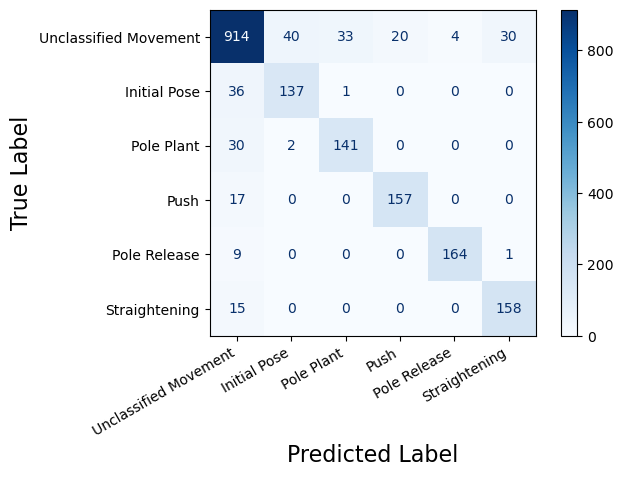

In [176]:
# Predict on the test data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming X_test and y_test are already defined and preprocessed
# Predict on the test data
predictions = model.predict(X_test)

# Print the shapes to debug
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of y_test: {y_test.shape}")

# # Reshape the predictions and y_test to remove the extra dimension
# predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
# y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])

# Print the shapes to debugs
print(f"Shape of predictions after reshaping: {predictions.shape}")
print(f"Shape of y_test after reshaping: {y_test.shape}")

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Print the shapes to debug
print(f"Shape of predicted_classes: {predicted_classes.shape}")
print(f"Shape of true_classes: {true_classes.shape}")

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Define your custom string labels
labels = ['Unclassified Movement', 'Initial Pose', 'Pole Plant', 'Push', 'Pole Release', 'Straightening']

# Display the confusion matrix with string labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax = disp.plot(cmap=plt.cm.Blues)
# Remove grid lines
ax.ax_.grid(False)  # Turn off the grid lines

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45)
# Optionally, adjust font size
plt.gcf().autofmt_xdate()  # Adjust layout to make room for diagonal labels
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)

# Save the figure as an EPS file
# plt.savefig('confusion_matrix.eps', format='eps', bbox_inches='tight')
plt.show()

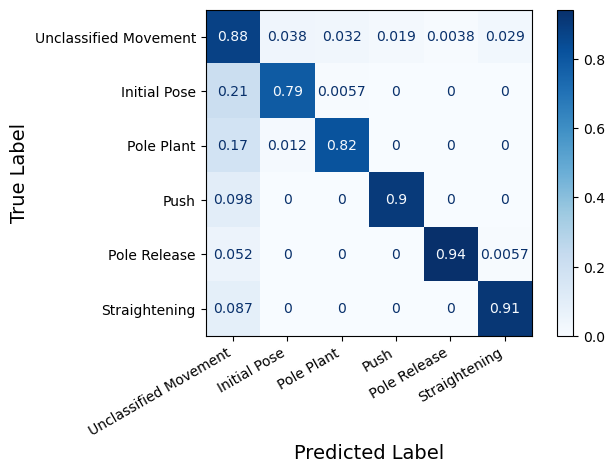

In [179]:
# Generate the normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Define your custom string labels
labels = ['Unclassified Movement', 'Initial Pose', 'Pole Plant', 'Push', 'Pole Release', 'Straightening']

# Display the confusion matrix with string labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
ax = disp.plot(cmap=plt.cm.Blues)
# Remove grid lines
ax.ax_.grid(False)  # Turn off the grid lines

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45)
# Optionally, adjust font size
plt.gcf().autofmt_xdate()  # Adjust layout to make room for diagonal labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Save the figure as an EPS file
plt.savefig('confusion_matrix_normalized_aug_4_128.eps', format='eps', bbox_inches='tight')
plt.show()

In [180]:
# Calculate overall accuracy from the confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy: {overall_accuracy: .2f}%")

# Generate the raw confusion matrix (for accuracy calculation)
cm_raw = confusion_matrix(true_classes, predicted_classes)

# Calculate overall accuracy from the raw confusion matrix
overall_accuracy = np.trace(cm_raw) / np.sum(cm_raw)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

Overall Accuracy:  0.87%
Overall Accuracy: 87.53%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1200x600 with 0 Axes>

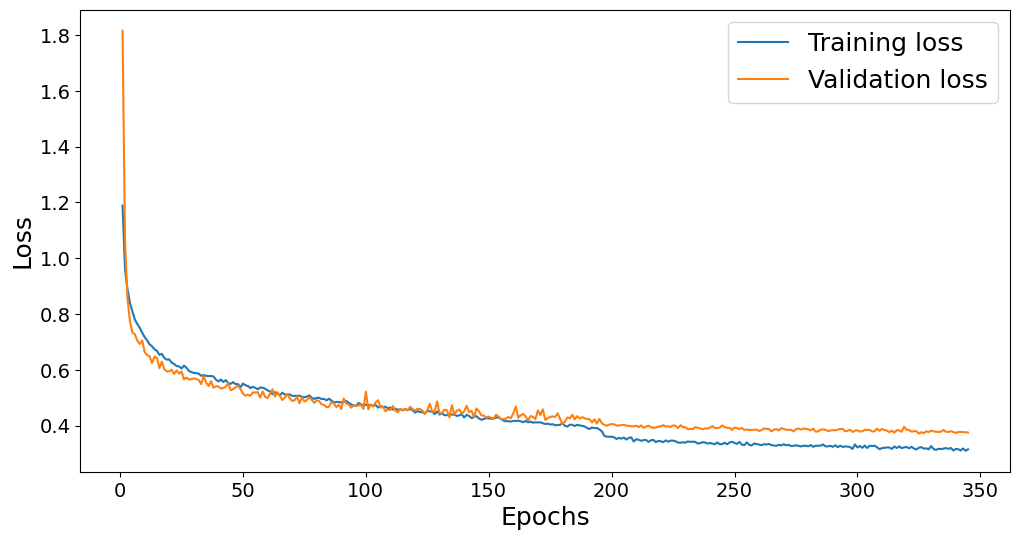

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


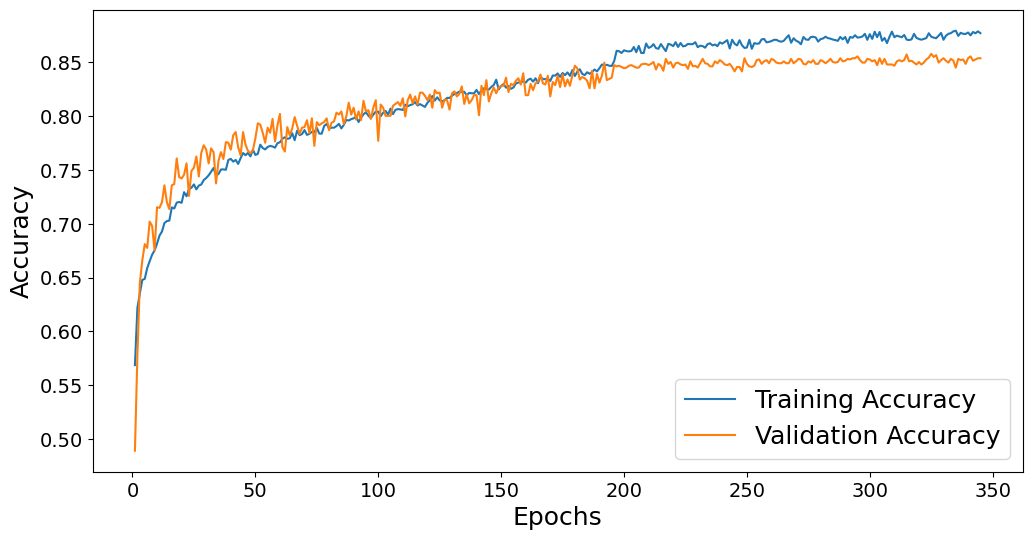

In [181]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from your model.fit() call
# Extracting the data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')

# Creating the plots
epochs = range(1, len(loss) + 1)

# Assuming 'epochs', 'loss', 'val_loss', 'accuracy', and 'val_accuracy' are defined
plt.figure(figsize=(12, 6))

# Plotting training and validation loss in a separate figure
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
#plt.title('Training and Validation Loss')
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)  # Turn off the grid
plt.savefig('training_loss_aug_4_128.eps', format='eps', bbox_inches='tight')  # Save if needed
plt.show()

# Plotting training and validation accuracy in a separate figure
if accuracy and val_accuracy:
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    # plt.title('Training and Validation Accuracy')
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)  # Turn off the grid
    plt.savefig('training_accuracy_aug_4_128.eps', format='eps', bbox_inches='tight')  # Save if needed
    plt.show()
